In [100]:
import csv
import pandas as pd
import numpy as np

name = '4'

def parse_text_to_csv(file_path):
    # Open the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract the data from the lines
    data = {}
    column_labels = []
    for line in lines:
        line = line.strip()
        if line:
            parts = line.split(':')
            if len(parts) == 2:
                label = parts[0].strip()
                value = parts[1].strip()
                if label not in column_labels:
                    column_labels.append(label)
                if label not in data:
                    data[label] = []
                data[label].append(value)

    # Write the data into a CSV file
    csv_file_path = file_path.replace('.txt', '.csv')
    with open(csv_file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(column_labels)
        max_rows = max(len(data[label]) for label in column_labels)
        for i in range(max_rows):
            row = [data[label][i] if i < len(data[label]) else '' for label in column_labels]
            writer.writerow(row)

    print(f"CSV file '{csv_file_path}' created successfully.")

# Usage example
file_path = f"./txt/{name}.txt"
parse_text_to_csv(file_path)

CSV file './txt/4.csv' created successfully.


In [101]:
# Read the CSV file
# df1 = pd.read_csv(f"./txt/1.csv")
df2 = pd.read_csv(f"./txt/2.csv")
df3 = pd.read_csv(f"./txt/3.csv")
df4 = pd.read_csv(f"./txt/4.csv")

# Print the DataFrame
# df1, df2

<Axes: xlabel='des'>

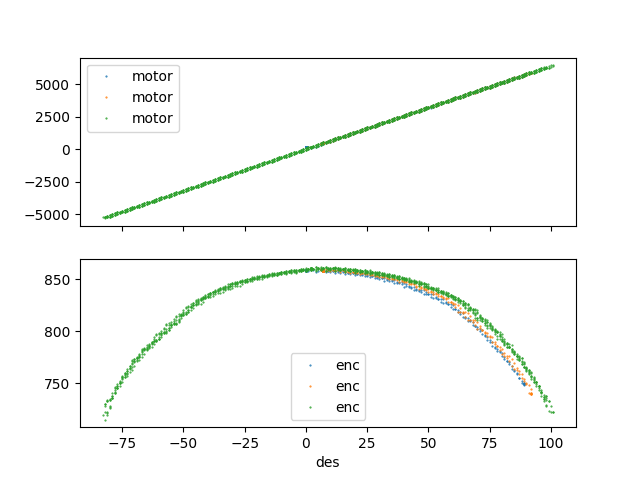

In [102]:
import matplotlib.pyplot as plt
%matplotlib widget

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# df1.plot('des', 'motor', style='.', markersize=1, ax=ax1)
df2.plot('des', 'motor', style='.', markersize=1, ax=ax1)
df3.plot('des', 'motor', style='.', markersize=1, ax=ax1)
df4.plot('des', 'motor', style='.', markersize=1, ax=ax1)
# df1.plot('des', 'enc', style='.', markersize=1, ax=ax2)
df2.plot('des', 'enc', style='.', markersize=1, ax=ax2)
df3.plot('des', 'enc', style='.', markersize=1, ax=ax2)
df4.plot('des', 'enc', style='.', markersize=1, ax=ax2)


Line equation:             4             3            2
-5.483e-14 x + 1.211e-10 x - 2.22e-06 x + 0.002702 x + 859


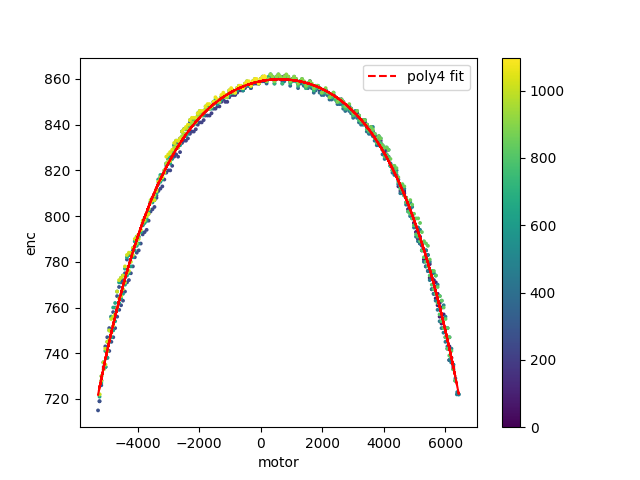

No such comm: a8ee3ef3df434015bc7c71bed2d92999


In [103]:
plt.figure()
# df.plot('motor', 'enc', style='-', markersize=3, c=df['motor'])
plt.scatter(df4['motor'], df4['enc'], s=3, c=df4.index)

plt.colorbar()


plt.xlabel('motor')
plt.ylabel('enc')
# plt.show()

# Fit a 2nd degree polynomial for enc vs motor
z = np.polyfit(df4['motor'], df4['enc'], 4)
p = np.poly1d(z)

# Plot the polynomial
plt.plot(df4['motor'], p(df4['motor']), "r--", label='poly4 fit')
plt.xlabel('motor')
plt.ylabel('enc')

plt.legend()
print(f"Line equation: {p}")


plt.show()


In [104]:
df4

,des,motor,enc
0,12,770,861
1,12,770,861
2,12,770,861
3,12,770,861
4,12,770,861
...,...,...,...
1094,2,125,861
1095,2,125,861
1096,2,125,861
1097,2,125,861


In [105]:
enc_zero = df4['enc'][0]
enc_start = np.deg2rad(-52.5)
motor_zero = df4['enc'][0]

df4['rad_out'] = -((df4['enc'] - enc_zero) *2*np.pi / 1024.0) + enc_start
df4['deg_out'] = np.rad2deg(df4['rad_out'])

df4['rad_in'] = (df4['motor'] - motor_zero) *2*np.pi / 256.0

r_motor_pivot = 65.683 #mm
df4["contract"] = np.sqrt(50**2 + r_motor_pivot**2 - 2*50*r_motor_pivot*np.cos(df4['rad_out']))

# df4[10:20]

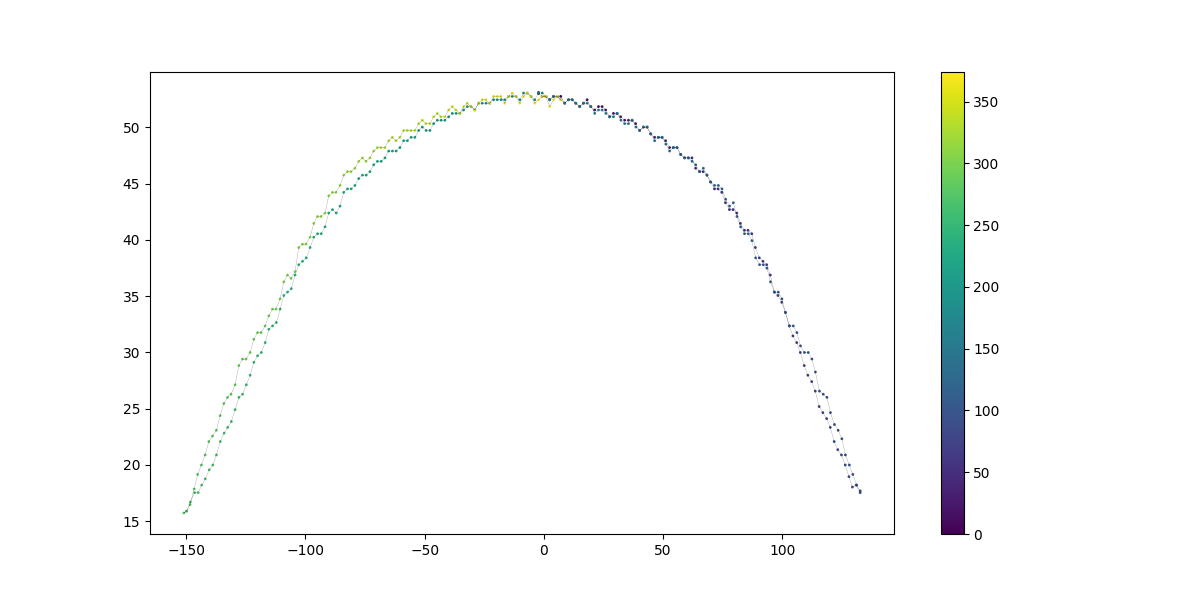

In [114]:
plt.close('all')

df_sub = df4[:375]
plt.figure(figsize=(12,6))

plt.scatter(df_sub['rad_in'], df_sub['contract'], s=1, c=df_sub.index)
plt.plot(df_sub['rad_in'], df_sub['contract'], 'k-', linewidth=0.1, markersize=0.1)

plt.colorbar()
plt.set_cmap('viridis')

z = np.polyfit(df_sub['rad_in'], df_sub['contract'], 4)
p = np.poly1d(z)
# plt.plot(df_sub['rad_in'], p(df_sub['rad_in']), "r--", linewidth=0.5, label='poly4 fit')
# plt.legend()
plt.show()

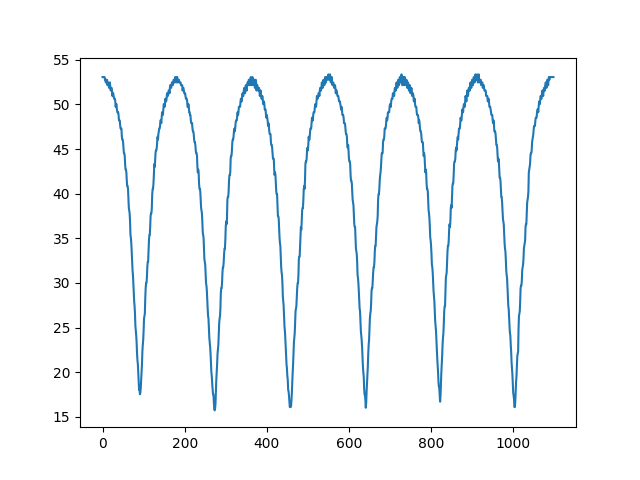

peaks:  [181 365 554 728 912]
minima:  [  91  273  457  641  822 1003]


In [166]:
plt.figure()
plt.plot(df4.index, df4['contract'])
plt.show()

from scipy.signal import find_peaks


peaks, _ = find_peaks(df4['contract'], prominence=10, distance=10)
minima, _ = find_peaks(-df4['contract'], prominence=10, distance=10)

df4['peaks'] = False
df4['minima'] = False

df4.loc[peaks, 'peaks'] = True
df4.loc[minima, 'minima'] = True

plt.scatter(df4.loc[peaks].index, df4.loc[peaks]['contract'], s=10, c='r')
plt.scatter(df4.loc[minima].index, df4.loc[minima]['contract'], s=10, c='b')

print("peaks: ", peaks)
print("minima: ", minima)




/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_24020/249459192.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'./png/{filename}'))
/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_24020/249459192.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'./png/{filename}'))


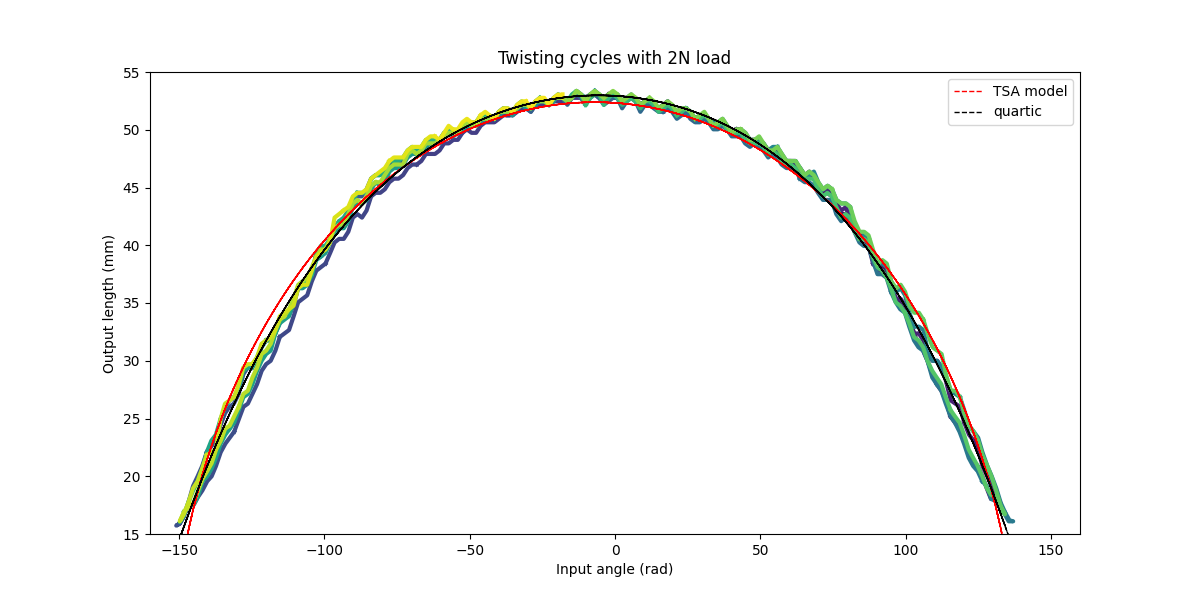

In [270]:
plt.close('all')

crit_pts = np.concatenate((peaks, minima, [df4.index[0], df4.index[-1]]))
crit_pts.sort()

plt.figure(figsize=(12,6))


import matplotlib as mpl
colors = mpl.colormaps['viridis'].resampled(len(df4))
from scipy.optimize import curve_fit

# colors = plt

for i in range(0, len(df4)-10, 10):
    # x = df4['rad_in'][crit_pts[i]:crit_pts[i+1]]
    # y = df4['contract'][crit_pts[i]:crit_pts[i+1]]
    x = df4['rad_in'][i:i+11]
    y = df4['contract'][i:i+11]

    # plt.plot(x, y, c=colors(i))
    # plt.clf()
    plt.xlim(-160, 160)
    plt.ylim(15, 55)
    plt.xlabel("Input angle (rad)")
    plt.ylabel("Output length (mm)")
    plt.title("Twisting cycles with 2N load")
    plt.plot(x, y, c=colors(i), alpha=1, linewidth=3)
    plt.savefig(f'./png/frame_{i:04d}.png')

def model(x, L, L0, r0, x0):
    return np.sqrt(np.clip(L**2 - (x+x0)**2 * r0**2, 0, None))

def quartic(x, a0, a1, a2, a3, a4):
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4

popt_model, pcov_model = curve_fit(model, df4['rad_in'], df4['contract'])
popt_quartic, pcov_quartic = curve_fit(quartic, df4['rad_in'], df4['contract'])

plt.plot(df4['rad_in'], model(df4['rad_in'], *popt_model), 'r--', label=f"TSA model", linewidth=1)
plt.plot(df4['rad_in'], quartic(df4['rad_in'], *popt_quartic), 'k--', label=f"quartic", linewidth=1)
plt.legend()
plt.savefig(f'./png/frame_9999.png')


import imageio
import os

images = []
for filename in sorted(os.listdir('./png/')):
    if filename.endswith('.png'):
        images.append(imageio.imread(f'./png/{filename}'))

for _ in range(30): #add 30 of the last frame at the end
    images.append(imageio.imread(f'./png/{filename}'))

imageio.mimsave('./png/animation.gif', images, fps=10, loop=0)

plt.show()


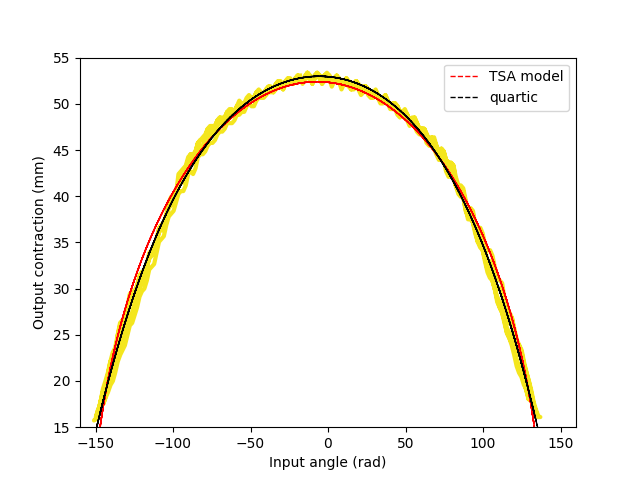

In [266]:


x = df4['rad_in']
y = df4['contract']

# plt.plot(x, y, c=colors(i))
# plt.clf()
plt.figure()
plt.xlim(-160, 160)
plt.ylim(15, 55)
plt.xlabel("Input angle (rad)")
plt.ylabel("Output contraction (mm)")
# plt.title("frame")
plt.plot(x, y, c=colors(i), alpha=1, linewidth=3)

def model(x, L, L0, r0, x0):
    return np.sqrt(np.clip(L**2 - (x+x0)**2 * r0**2, 0, None))

def quartic(x, a0, a1, a2, a3, a4):
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4

popt_model, pcov_model = curve_fit(model, df4['rad_in'], df4['contract'])
popt_quartic, pcov_quartic = curve_fit(quartic, df4['rad_in'], df4['contract'])

plt.plot(df4['rad_in'], model(df4['rad_in'], *popt_model), 'r--', label=f"TSA model", linewidth=1)
plt.plot(df4['rad_in'], quartic(df4['rad_in'], *popt_quartic), 'k--', label=f"quartic", linewidth=1)
plt.legend()
plt.show()

